# 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

# 1. 데이터 로드

In [2]:
df = pd.read_excel('../데이터/최종본.xlsx')
df.head()

,year,month,day,ws,ta,hm,rn,result
0,2019,1,1,3.0,4.1,36,0.0,0
1,2019,1,2,3.9,4.2,30,0.0,1
2,2019,1,3,5.1,5.3,20,0.0,1
3,2019,1,4,5.8,6.3,20,0.0,0
4,2019,1,5,4.4,7.0,40,0.0,1


In [3]:
result_counts = df['result'].value_counts(normalize=True) * 100  # 비율(%)
print("result 0과 1의 비율:")
print(result_counts)

result 0과 1의 비율:
result
0    75.945205
1    24.054795
Name: proportion, dtype: float64


# 2. 특징과 레이블 선택

In [4]:
df = df.drop('year', axis=1)
df.head()

,month,day,ws,ta,hm,rn,result
0,1,1,3.0,4.1,36,0.0,0
1,1,2,3.9,4.2,30,0.0,1
2,1,3,5.1,5.3,20,0.0,1
3,1,4,5.8,6.3,20,0.0,0
4,1,5,4.4,7.0,40,0.0,1


In [5]:
df_encoded = pd.get_dummies(df, columns=['month', 'day'], prefix=['month', 'day'])
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 48 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ws        1825 non-null   float64
 1   ta        1825 non-null   float64
 2   hm        1825 non-null   int64  
 3   rn        1825 non-null   float64
 4   result    1825 non-null   int64  
 5   month_1   1825 non-null   bool   
 6   month_2   1825 non-null   bool   
 7   month_3   1825 non-null   bool   
 8   month_4   1825 non-null   bool   
 9   month_5   1825 non-null   bool   
 10  month_6   1825 non-null   bool   
 11  month_7   1825 non-null   bool   
 12  month_8   1825 non-null   bool   
 13  month_9   1825 non-null   bool   
 14  month_10  1825 non-null   bool   
 15  month_11  1825 non-null   bool   
 16  month_12  1825 non-null   bool   
 17  day_1     1825 non-null   bool   
 18  day_2     1825 non-null   bool   
 19  day_3     1825 non-null   bool   
 20  day_4     1825 non-null   bool

In [6]:
X = df_encoded.drop(columns=['result'])  # result 열을 제외한 모든 열
y = df_encoded['result']  # 레이블

# 3. 데이터 분할
(훈련/검증 세트, 비율: 90:10)   

In [7]:
# 훈련 세트와 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [8]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

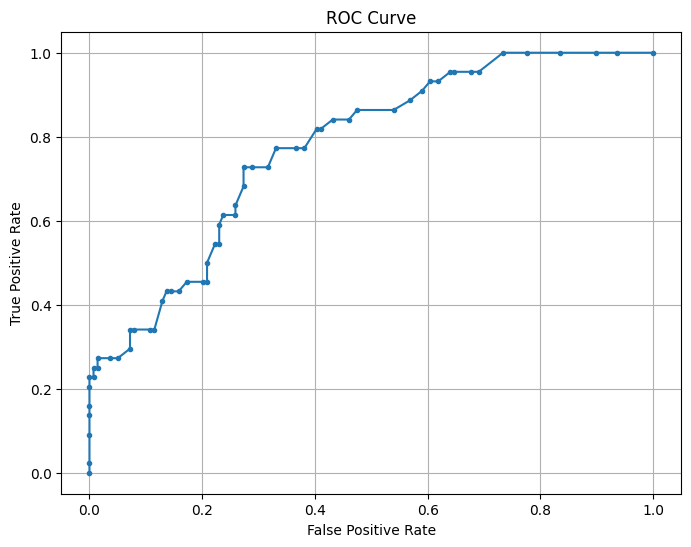

Optimal Threshold: 0.29


In [9]:
import matplotlib.pyplot as plt

# 예측 확률
y_scores = model.predict_proba(X_test)[:, 1]

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()

# 최적의 threshold 찾기 (TPR와 FPR의 차이가 가장 큰 지점)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# 5. 예측 및 평가

In [10]:
# 최적의 threshold를 사용하여 예측
y_val_pred = (y_scores >= optimal_threshold).astype(int)

# 모델 평가
print("검증 세트 정확도:", accuracy_score(y_test, y_val_pred))
print("검증 세트 ROC AUC 점수:", roc_auc_score(y_test, y_scores))
print("검증 세트 보고서:\n", classification_report(y_test, y_val_pred))

검증 세트 정확도: 0.726775956284153
검증 세트 ROC AUC 점수: 0.7755068672334859
검증 세트 보고서:
               precision    recall  f1-score   support

           0       0.89      0.73      0.80       139
           1       0.46      0.73      0.56        44

    accuracy                           0.73       183
   macro avg       0.68      0.73      0.68       183
weighted avg       0.79      0.73      0.74       183



In [11]:
test_pred = model.predict(X_test)

# 모델 평가
print("검증 세트 정확도:", accuracy_score(y_test, test_pred))
print("검증 세트 ROC AUC 점수:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
print("검증 세트 보고서:\n", classification_report(y_test, test_pred))

검증 세트 정확도: 0.7868852459016393
검증 세트 ROC AUC 점수: 0.7755068672334859
검증 세트 보고서:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       139
           1       0.60      0.34      0.43        44

    accuracy                           0.79       183
   macro avg       0.71      0.63      0.65       183
weighted avg       0.76      0.79      0.76       183



In [33]:
test_pred_proba = model.predict_proba(X_test)[:, 1]  # 양성 클래스에 대한 확률

# 7. 테스트 세트와 예측 결과 출력
test_results = pd.DataFrame({
    '정답': y_test,
    '예측': test_pred,
    '예측 확률': test_pred_proba,
    '풍속 (ws)': X_test['ws'].values,
    '기온 (ta)': X_test['ta'].values,
    '습도 (hm)': X_test['hm'].values,
    '일일강수량 (rn)': X_test['rn'].values
})

In [34]:
print("\n테스트 세트 결과:")
test_results.sample(15)


테스트 세트 결과:


,정답,예측,예측 확률,풍속 (ws),기온 (ta),습도 (hm),일일강수량 (rn)
1354,0,0,0.04,2.0,28.6,75,0.0
1188,0,1,0.52,4.7,15.9,58,0.0
1056,0,0,0.42,5.3,9.7,43,0.0
774,0,0,0.03,2.0,12.6,94,4.4
501,0,0,0.01,3.6,24.2,72,0.6
269,0,0,0.00,2.7,24.7,74,0.0
312,0,0,0.11,3.3,20.1,37,0.0
1349,0,0,0.04,2.7,26.4,76,0.0
438,1,1,0.83,5.1,9.4,20,0.0
1393,0,0,0.32,2.5,21.2,49,0.0


# 6. 피처 중요도

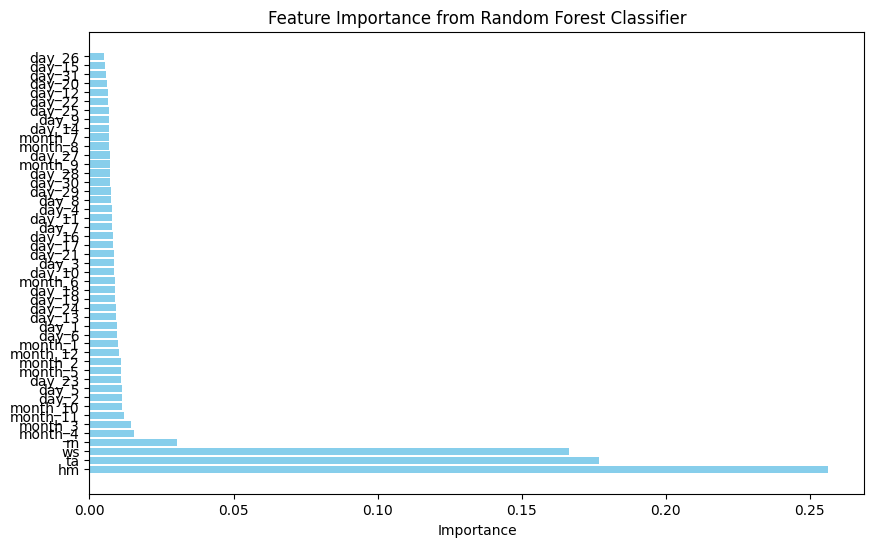

In [35]:
# 특성 중요도 가져오기
importances = model.feature_importances_

# 피처 이름과 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# 중요도 기준으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()